In [2]:
import pandas as pd
import numpy as np
from datetime import datetime
import seaborn as sns
import re
import matplotlib.pyplot as plt
pd.set_option('display.float_format', lambda x: '%.2f' % x)
import matplotlib.pyplot as plt
from IPython.display import display
pd.options.display.max_columns = None
from sklearn.linear_model import Lasso, Ridge, LassoCV, RidgeCV

In [3]:
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression, Ridge #ordinary linear regression + w/ ridge regularization
from sklearn.preprocessing import StandardScaler, PolynomialFeatures
from sklearn.model_selection import cross_val_score

### Import & Housekeeping

In [4]:
movie_df = pd.read_csv('../04_Data/2008_2017_merged_featurized.csv', index_col=0)

In [5]:
#Set groups of column names to make subsequent plots modular
target = ["usa_box"]
info = ["prod_budget", 'series', 'imax', "runtime"]  #,"genre_counts" '3d', , "year"
theater = ["title", "theaters"]
mpaa = ["PG", "R"] #"G", "PG-13", 
genre = ["action", "comedy", "drama", "horror", "scifi/fantasy", "romance", "animation", "other"]

columns = info + mpaa + genre + theater + target  #this is all the columns

In [6]:
#isolate the columns with features and target
movie_df = movie_df[columns]

In [7]:
#clean & isolate

#this removes from the set any movie less than 600 Theater Locations (aka Limited Release)
movie_df = movie_df[movie_df["theaters"]>=600] 

#this removes from the set any movie with no production budget
movie_df = movie_df.dropna(how='any').reset_index()

In [8]:
movie_df.shape   #1369 Movies that contain a budget on The-Numbers.com

(1369, 18)

In [9]:
movie_df.info()   #no null values

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1369 entries, 0 to 1368
Data columns (total 18 columns):
index            1369 non-null int64
prod_budget      1369 non-null float64
series           1369 non-null float64
imax             1369 non-null float64
runtime          1369 non-null float64
PG               1369 non-null int64
R                1369 non-null int64
action           1369 non-null int64
comedy           1369 non-null int64
drama            1369 non-null int64
horror           1369 non-null int64
scifi/fantasy    1369 non-null int64
romance          1369 non-null int64
animation        1369 non-null int64
other            1369 non-null int64
title            1369 non-null object
theaters         1369 non-null float64
usa_box          1369 non-null float64
dtypes: float64(6), int64(11), object(1)
memory usage: 192.6+ KB


### Set Columns For Study

In [10]:
X_columns = info + mpaa + genre

In [11]:
y = movie_df["usa_box"]
X = movie_df.loc[:,X_columns]

### Partition data + Make KFolds

In [12]:
#hold out 20% of the data for final testing
X, X_test, y, y_test = train_test_split(X, y, test_size=.2, random_state=20) #keep at 20 to be consistent

#hold out 20% for validation
X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=.25, random_state=3) 

In [13]:
from sklearn.model_selection import KFold
kf = KFold(n_splits=5, shuffle=True, random_state = 71)

#this helps with the way kf will generate indices below
# X, y = np.array(X), np.array(y)

### Scale Data - Hold for Regularization Later

In [14]:
#Feature scaling for train, val
scaler = StandardScaler()

X_scaled = scaler.fit_transform(X)           #Scale set for Regularization
X_test_scaled = scaler.transform(X_test)

X = scaler.fit_transform(X)                  #scale set for everything
X_test = scaler.transform(X_test)

### Model 1A:  Cross Validation - Linear Regression

In [15]:
lmcv = LinearRegression()

linear_model = cross_val_score(lmcv, X, y,    # estimator, features, target
                                cv=kf,        # number of folds 
                                scoring='r2') # scoring metric

In [16]:
print(linear_model)
print(linear_model.mean())

[0.54265084 0.56220411 0.58000795 0.54529351 0.49000026]
0.5440313328973521


In [17]:
lmcv.fit(X,y)

LinearRegression(copy_X=True, fit_intercept=True, n_jobs=1, normalize=False)

In [18]:
lmcv.score(X_test,y_test)

0.5947499023570755

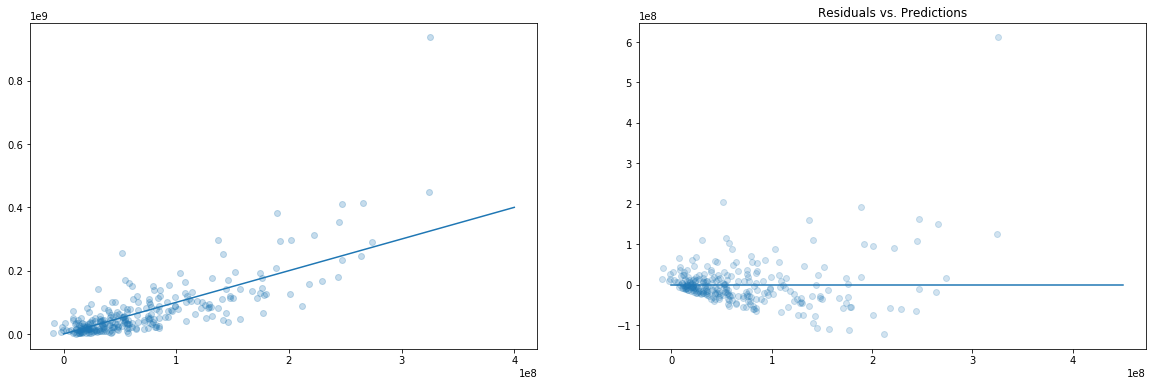

In [20]:
plt.figure(figsize=(20,6))

# Fitted vs. Actual
y_pred = lmcv.predict(X_test)

plt.subplot(1, 2, 1)
plt.scatter(y_pred, y_test, alpha=0.25)
plt.plot([0, 400000000], [0, 400000000])
plt.savefig("actual_v_pred.pdf")

# Residuals
lin_reg_residuals = y_test - y_pred

plt.subplot(1, 2, 2)
plt.scatter(y_pred, lin_reg_residuals, alpha=.2)
plt.plot([0,450000000], [0, 0])
plt.title("Residuals vs. Predictions")
plt.savefig("residuals.pdf");

In [20]:
# These are the coefficients when it refit using that best alpha
list(zip(X_columns,lmcv.coef_))

[('prod_budget', 42614804.43893505),
 ('series', 23183943.25463718),
 ('imax', 8707183.611522531),
 ('runtime', 10437893.665104471),
 ('PG', 448064.39363877266),
 ('R', -963760.0287641695),
 ('action', -4442314.88761095),
 ('comedy', 1590576.4709906403),
 ('drama', -1672229.075937453),
 ('horror', -2108131.6391423238),
 ('scifi/fantasy', -3733377.3672413873),
 ('romance', 3012639.3866967256),
 ('animation', 6940871.078143268),
 ('other', -3346190.665015457)]

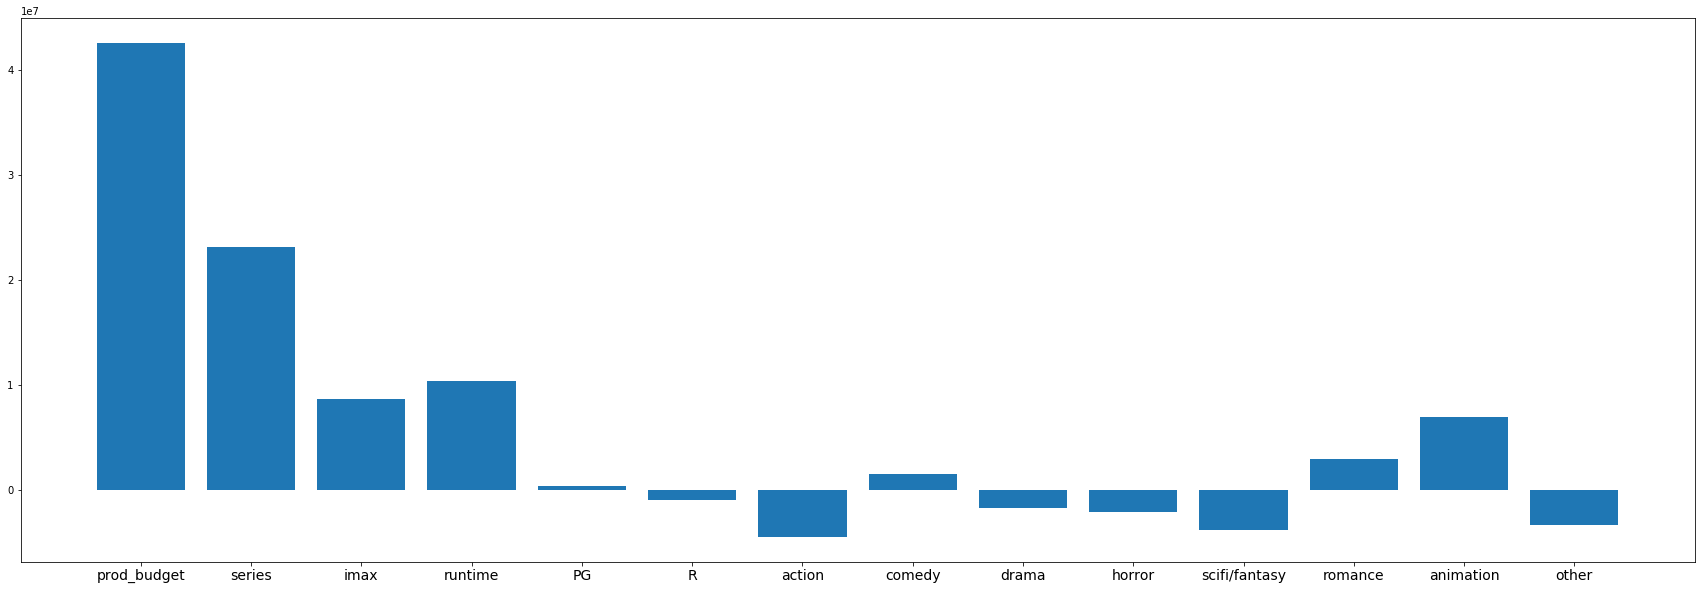

In [21]:
plt.figure(figsize=(30,10))
plt.rc('xtick', labelsize=14)
plt.bar(X_columns,lmcv.coef_)
plt.savefig("Feature_Graph.pdf");

In [89]:
#RMSE
np.sqrt(np.mean((y_pred - y_test)**2))

58574396.11728058

### Model 2A: Cross Validation - Ridge Regression

In [90]:
lm_reg_cv = Ridge(alpha=1)

ridge_model =  cross_val_score(lm_reg_cv, X, y,    # estimator, features, target
                                cv=kf,             # number of folds 
                                scoring='r2')      # scoring metric

In [91]:
print(ridge_model)
print(ridge_model.mean())

[0.54269277 0.5620881  0.58013989 0.54521066 0.49024804]
0.5440758920744725


### Model 3A: Polynomial CV

In [92]:
#Feature transforms for train, val, and test so that we can run our poly model on each
poly = PolynomialFeatures(degree=2) 

X_poly = poly.fit_transform(X)
#X_test_poly = poly.transform(X_test)

lm_poly = LinearRegression()

poly_model =  cross_val_score(lm_poly, X_poly, y,    # estimator, features, target
                                cv=kf,                # number of folds 
                                scoring='r2')         # scoring metric

In [93]:
print(poly_model)
print(poly_model.mean())

[-1.70921896e+23  5.04652287e-01  4.81038592e-01  5.33067545e-01
  4.74797132e-01]
-3.4184379214001737e+22


### Model 4A: Cross Validation - Lasso

In [94]:
lasso_model = Lasso(alpha = 587801.6072274924)  #this is a HIGH regularization strength!

lasso_model_cv = cross_val_score(lasso_model, X, y,    # estimator, features, target
                                cv=kf,        # number of folds 
                                scoring='r2') # scoring metric

In [95]:
print(lasso_model_cv)
print(lasso_model_cv.mean())

[0.54186235 0.56346255 0.58233428 0.54362161 0.49030465]
0.5443170862435609


In [96]:
lasso_model.fit(X,y)

Lasso(alpha=587801.6072274924, copy_X=True, fit_intercept=True, max_iter=1000,
   normalize=False, positive=False, precompute=False, random_state=None,
   selection='cyclic', tol=0.0001, warm_start=False)

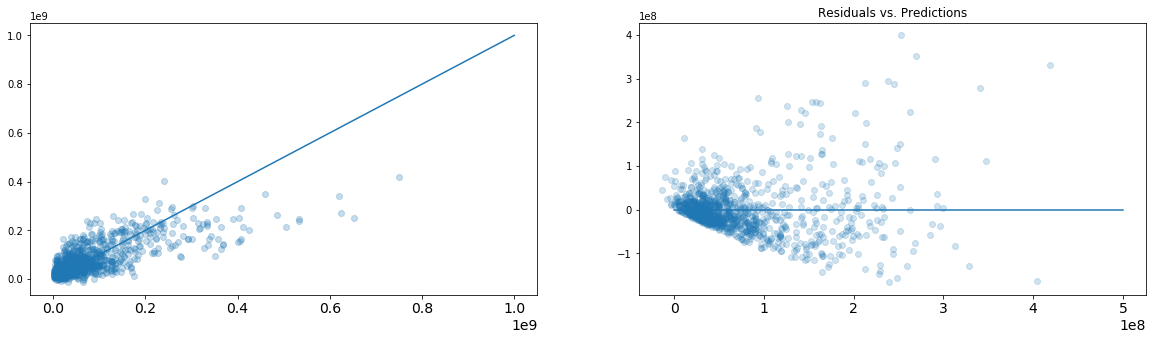

In [97]:
plt.figure(figsize=(20,5))

# Fitted vs. Actual
y_pred = lasso_model.predict(X)

plt.subplot(1, 2, 1)
plt.scatter(y, y_pred, alpha=0.25)
plt.plot([0, 1000000000], [0, 1000000000])

# Residuals
lin_reg_residuals = y - y_pred

plt.subplot(1, 2, 2)
plt.scatter(y_pred, lin_reg_residuals, alpha=.2)
plt.plot([0,500000000], [0, 0])
plt.title("Residuals vs. Predictions");

In [98]:
# These are the coefficients when it refit using that best alpha
list(zip(X_columns,lasso_model.coef_))

[('prod_budget', 42890497.611043505),
 ('series', 22891806.397621267),
 ('imax', 8169695.733056341),
 ('runtime', 9313577.265452206),
 ('PG', 125538.63163548989),
 ('R', -607174.016946075),
 ('action', -2958139.8859713213),
 ('comedy', 1930975.974485443),
 ('drama', -98810.00027731815),
 ('horror', -1181783.721595971),
 ('scifi/fantasy', -2533924.473029429),
 ('romance', 2909918.379599209),
 ('animation', 7225788.725583922),
 ('other', -2157220.4558693334)]

### Model 5: Lasso CV

In [99]:
# Run the cross validation, find the best alpha, refit the model on all the data with that alpha

alphavec = 10**np.linspace(-3,9,27)

lr_model_4A = LassoCV(alphas = alphavec, cv=5)
lr_model_4A.fit(X_scaled,y)

LassoCV(alphas=array([1.00000e-03, 2.89427e-03, 8.37678e-03, 2.42446e-02, 7.01704e-02,
       2.03092e-01, 5.87802e-01, 1.70125e+00, 4.92388e+00, 1.42510e+01,
       4.12463e+01, 1.19378e+02, 3.45511e+02, 1.00000e+03, 2.89427e+03,
       8.37678e+03, 2.42446e+04, 7.01704e+04, 2.03092e+05, 5.87802e+05,
       1.70125e+06, 4.92388e+06, 1.42510e+07, 4.12463e+07, 1.19378e+08,
       3.45511e+08, 1.00000e+09]),
    copy_X=True, cv=5, eps=0.001, fit_intercept=True, max_iter=1000,
    n_alphas=100, n_jobs=1, normalize=False, positive=False,
    precompute='auto', random_state=None, selection='cyclic', tol=0.0001,
    verbose=False)

In [100]:
# This is the best alpha value it found
lr_model_4A.alpha_

587801.6072274924